In [ ]:
import time
import seaborn as sns

import jax
import matplotlib.pyplot as plt
import optax
from orbax.checkpoint import PyTreeCheckpointer
from flax.training.train_state import TrainState

from lotf import LOTF_PATH
from lotf.algos import bptt
from lotf.envs import HoveringFeaturesEnv
from lotf.envs.wrappers import LogWrapper, VecEnv
from lotf.modules import MLP
from lotf.objects import Quadrotor

# Training a Feature-Based Hovering Policy With BPTT

## 1. Seed

In [2]:
seed = 0
key = jax.random.key(seed)
key_init, key_bptt = jax.random.split(key, 2)

## 2. Define Simulation Dynamics Config and Training Params

In [3]:
# simulation dynamics config
sim_dyn_config = {
    "use_high_fidelity": False,          # whether to use high-fidelity dynamics in forward simulation
    "use_forward_residual": False,       # whether to use residual dynamics in forward simulation
}

# training parameters
num_envs = 300
max_epochs = 200

## 3. Create Quadrotor Object and Simulation Environment

In [4]:
# simulation parameters
sim_dt = 0.02
max_sim_time = 3.0

# quadrotor object
quad_obj = Quadrotor.from_name("example_quad", sim_dyn_config)

# simulation environment
env = HoveringFeaturesEnv(
    max_steps_in_episode=int(max_sim_time / sim_dt),
    dt=sim_dt,
    delay=0.04,
    yaw_scale=1.0,
    pitch_roll_scale=0.1,
    velocity_std=0.1,
    omega_std=0.1,
    quad_obj=quad_obj,
    reward_sharpness=2.0,
    action_penalty_weight=0.5,
    num_last_quad_states=15,
    skip_frames=3,
    margin=0.5,
    hover_target=[1.5, 0.0, 1.5],
)

# get dimensions
action_dim = env.action_space.shape[0]
obs_dim = env.observation_space.shape[0]

# apply additional wrappers
env = LogWrapper(env)
env = VecEnv(env)

print("====== env info ======")
print(f"action_dim: {action_dim}")
print(f"obs_dim: {obs_dim}")
print(f"target hover goal: {env.goal}")

====== env info ======
action_dim: 4
obs_dim: 82
target hover goal: [1.5 0.  1.5]


## 4. Load Pretrained Policy Network, Optimizer, and Train State

In [5]:
pretrained_policy_name = "vision_hovering_pre_params"

# policy network and load pretrained parameters
policy_net = MLP(
    [obs_dim, 512, 512, action_dim],
    initial_scale=0.01,
    action_bias=env.hovering_action,
)
path = LOTF_PATH + "/../checkpoints/policy/" + pretrained_policy_name
ckptr = PyTreeCheckpointer()
pretrained_params = ckptr.restore(path)

# optimizer
scheduler = optax.cosine_decay_schedule(1e-3, max_epochs)
tx = optax.adam(scheduler)

# train state
train_state = TrainState.create(
    apply_fn=policy_net.apply, params=pretrained_params, tx=tx
)

## 5. Load Dummy Residual Dynamics Network Parameters

In [6]:
# NOTE: Since we are training a base policy, we do not actually use the residual dynamics for forward sim or backprop
# However, we simply load a dummy residual dynamics model to satisfy the simulation environment requirements

path = LOTF_PATH + "/../checkpoints/residual_dynamics/dummy_params"
ckptr = PyTreeCheckpointer()
dummy_residual_params = ckptr.restore(path)

## 6. Train

In [7]:
# intialize environments
key_bptt, key_ = jax.random.split(key_bptt)
key_reset = jax.random.split(key_, num_envs)
init_env_state, init_obs = env.reset(key_reset, None)

# training loop
time_start = time.time()
res_dict = bptt.train(
    env,
    init_env_state,
    init_obs,
    train_state,
    num_epochs=max_epochs,
    num_steps_per_epoch=env.max_steps_in_episode,
    num_envs=num_envs,
    res_model_params=dummy_residual_params,
    key=key_bptt,
)
time_train_compile = time.time() - time_start
print(f"Compile + Training time: {time_train_compile}")

Episode: 0, Grad max: 0.7690
Episode: 0, Loss: 11.85
Episode: 10, Grad max: 0.2990
Episode: 10, Loss: 8.64
Episode: 20, Grad max: 0.8120
Episode: 20, Loss: 6.21
Episode: 30, Grad max: 1.2038
Episode: 30, Loss: 3.75
Episode: 40, Grad max: 0.7693
Episode: 40, Loss: 2.74
Episode: 50, Grad max: 1.0232
Episode: 50, Loss: 2.00
Episode: 60, Grad max: 0.4388
Episode: 60, Loss: 1.64
Episode: 70, Grad max: 0.4495
Episode: 70, Loss: 1.40
Episode: 80, Grad max: 0.6836
Episode: 80, Loss: 1.39
Episode: 90, Grad max: 0.9878
Episode: 90, Loss: 1.33
Episode: 100, Grad max: 0.8763
Episode: 100, Loss: 1.32
Episode: 110, Grad max: 0.3547
Episode: 110, Loss: 1.14
Episode: 120, Grad max: 0.2915
Episode: 120, Loss: 1.15
Episode: 130, Grad max: 0.3129
Episode: 130, Loss: 1.08
Episode: 140, Grad max: 0.2119
Episode: 140, Loss: 1.08
Episode: 150, Grad max: 0.2353
Episode: 150, Loss: 1.01
Episode: 160, Grad max: 0.1575
Episode: 160, Loss: 1.03
Episode: 170, Grad max: 0.1045
Episode: 170, Loss: 1.04
Episode: 180,

## 7. Plot Rewards

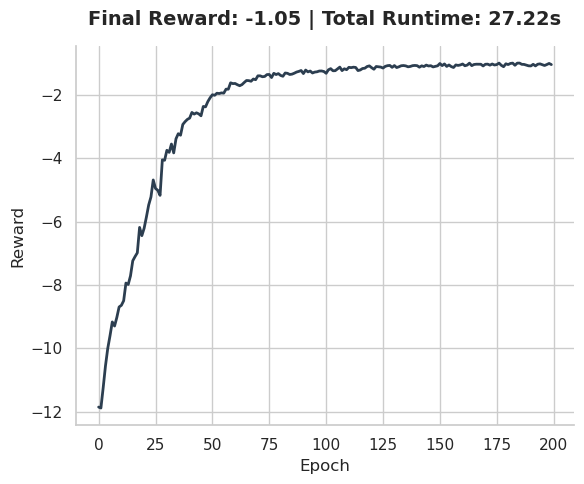

In [8]:
losses = res_dict['metrics']
returns = -losses

sns.set_theme(style="whitegrid")
plt.figure(figsize=(6, 5))
plt.plot(returns, color='#2c3e50', linewidth=2)
plt.title(f"Final Reward: {returns[-1]:.2f} | Total Runtime: {time_train_compile:.2f}s", 
          fontsize=14, fontweight='bold', pad=15)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.tight_layout()
sns.despine()
plt.show()

## 8. (Optional) Save the Policy Checkpoint

In [9]:
policy_name = "my_vision_hovering_params"

path = LOTF_PATH + "/../checkpoints/policy/" + policy_name
ckptr = PyTreeCheckpointer()
trained_policy_params = res_dict["runner_state"].train_state.params
ckptr.save(path, trained_policy_params)
print(f"Policy saved successfully!")

Policy saved successfully!
